### Load Data

In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import re
import ipaddress

In [2]:
test_set = r"Hackathon_CP_2019_Data\Test_Set_Hackathon.csv"
train_benign = r'Hackathon_CP_2019_Data\Train_benign_traffic.csv'
train_detections = r'Hackathon_CP_2019_Data\Train_Detections.csv'
train_ips = r'Hackathon_CP_2019_Data\Train_ips.csv'

In [3]:
df_test = pd.read_csv(test_set, encoding='latin1')
df_benign = pd.read_csv(train_benign, encoding='latin1')
df_mal = pd.read_csv(train_detections, encoding='latin1')

In [4]:
def port_features(dataframe):
    """Returns the dataframe with an added feature of whether the port was the DNS port"""
    dataframe['is_port_53'] = dataframe['dst_port'] == 53
    dataframe['is_port_80'] = dataframe['dst_port'] == 80
    return dataframe

def add_ip_features(dataframe):
    """Returns the dataframe with added columns defining if the source/dest ip is public or private 
    as well as the pair"""
    def type_ip(x):
        try:
            if ipaddress.ip_address(x).is_private:
                return 'Private'
            else:
                return 'Public'
        except ValueError:
            return 'invalid'

    dataframe['dst_type'] = dataframe['dst_ip'].apply(type_ip)
    dataframe['src_type'] = dataframe['src_ip'].apply(type_ip)
    dataframe['ip_pair'] = dataframe['src_type'] + dataframe['dst_type']
    dataframe = dataframe.drop(dataframe[dataframe['dst_type'] == 'invalid'].index)
    
    return dataframe

In [5]:
def ip_network_class(ip):
    """Takes an IP address and returns the class of the IP"""
    try:
        pattern = r'([\d]+).([\d]+).([\d]+).([\d]+)'
        match = re.search(pattern, ip)
        ip_key = int(match.group(1))
        if ip_key < 127:
            return 'A'
        elif ip_key < 192:
            return 'B'
        elif ip_key < 224:
            return 'C'
        elif ip_key < 240:
            return 'D'
        elif ip_key < 256:
            return 'E'
        return
    except:
        return 0


def get_network_host(ip, host=False):
    """Returns the network portion of the IP address or the host portion of the ip address"""
    try:
        pattern = r'([\d]+).([\d]+).([\d]+).([\d]+)'
        match = re.search(pattern, ip)
        ip_key = int(match.group(1))
        if ip_key < 127:
            if host:
                return re.search(r'([\d]+).([\d]+.[\d]+.[\d]+)', ip).group(2)
            match = re.search(r'([\d]+).([\d]+).([\d]+).([\d]+)', ip).group(1)
            return match
        elif ip_key < 192:
            if host:
                return re.search(r'([\d]+.[\d]+).([\d]+.[\d]+)', ip).group(2)
            match = re.search(r'([\d]+.[\d]+).([\d]+).([\d]+)', ip).group(1)
            return match
        elif ip_key < 224:
            if host:
                return re.search(r'([\d]+.[\d]+.[\d]+).([\d]+)', ip).group(2)
            match = re.search(r'([\d]+.[\d]+.[\d]+).([\d]+)', ip).group(1)
            return match
        return '0'
    except:
        return '0'


def zero_sent_received(df):
    """Returns the dataframe with an added column indicating if the recieved and sent
     bytes are both zero"""
    df['ZeroSentReceived'] = (df.received_bytes + df.sent_bytes) == 0
    return df


def network_properties(df):
    """Create columns related to the source and destination IP adresses:
    - The type of class of each IP
    - The network portion of the IP
    - the Host portion of the IP"""
    source_cols = list(df.columns)
    df['sourceClass'] = df.src_ip.apply(ip_network_class)
    df['destClass'] = df.dst_ip.apply(ip_network_class)
    df['sourceNetwork'] = df.src_ip.apply(get_network_host)
    df['destNetwork'] = df.dst_ip.apply(get_network_host)
    df['sourceHost'] = df.src_ip.apply(lambda x: get_network_host(x, True))
    df['destHost'] = df.dst_ip.apply(lambda x: get_network_host(x, True))
    df = pd.get_dummies(df, columns=['sourceClass', 'destClass'])
    new_cols = source_cols + ['sourceClass_A', 'sourceClass_B', 'sourceClass_C', 'destClass_A', 'destClass_B', 'destClass_C',
                             'sourceNetwork', 'destNetwork', 'sourceHost', 'destHost']
    extract_cols = [c for c in new_cols if c in df.columns]
    return df[extract_cols]

In [6]:
def target_network(df):
    """Returns the dataframe with an added column indicating if the recieved and sent
     bytes are both zero"""
    df['DestNetwork10'] = df.destNetwork == '10'
    df['DestNetwork8'] = df.destNetwork == '8'
    df['DestNetwork70'] = df.destNetwork == '70'
    return df

In [7]:
def add_features(df):
    df = port_features(df)
    df = add_ip_features(df)
    df = zero_sent_received(df)
    df = network_properties(df)
    df = target_network(df)
    df['sourceClass'] = df.src_ip.apply(ip_network_class)
    df['destClass'] = df.dst_ip.apply(ip_network_class)
    return df

In [8]:
df_test = add_features(df_test)
df_benign = add_features(df_benign)
df_mal = add_features(df_mal)

In [9]:
df_test.columns

Index(['Unnamed: 0', 'client', 'dst_ip', 'dst_port', 'protocol',
       'received_bytes', 'sent_bytes', 'src_ip', 'is_port_53', 'is_port_80',
       'dst_type', 'src_type', 'ip_pair', 'ZeroSentReceived', 'sourceClass_A',
       'sourceClass_B', 'sourceClass_C', 'destClass_A', 'destClass_B',
       'destClass_C', 'sourceNetwork', 'destNetwork', 'sourceHost', 'destHost',
       'DestNetwork10', 'DestNetwork8', 'DestNetwork70', 'sourceClass',
       'destClass'],
      dtype='object')

In [10]:
df_test.head()

Unnamed: 0  client          dst_ip  dst_port protocol  received_bytes  \
0           0       2     230.0.0.251    5353.0      UDP               0   
1           1       2   24.234.32.175     443.0      TCP           15200   
2           2       2  10.200.105.183     443.0      TCP            4712   
3           3       5  178.217.10.142     443.0      TCP           52352   
4           4       5    44.67.14.232      80.0      TCP              92   

   sent_bytes         src_ip  is_port_53  is_port_80    ...     destClass_C  \
0         816  10.197.208.76       False       False    ...               0   
1         374  10.197.208.78       False       False    ...               0   
2        5760  10.200.44.127       False       False    ...               0   
3      114560     10.0.11.80       False       False    ...               0   
4         132     10.0.11.94       False        True    ...               0   

  sourceNetwork destNetwork  sourceHost     destHost  DestNetwork10  \
0            10           0  197.208.76            0          False   
1            10          24  197.208.78   234.32.175          False   
2            10          10  200.44.127  200.105.183           True   
3            10     178.217     0.11.80       10.142          False   
4            10          44     0.11.94    67.14.232          False   

   DestNetwork8  DestNetwork70  sourceClass  destClass  
0         False          False            A          D  
1         False          False            A          A  
2         False          False            A          A  
3         False          False            A          B  
4         False          False            A          A  

[5 rows x 29 columns]

In [11]:
def hist_compare(df_mal, df_ben, feature, limit=None):
    mal_vals = df_mal[feature].value_counts()
    mal_tot = sum(mal_vals)
    mal_vals_i = mal_vals.index
    ben_vals = df_ben[feature].value_counts()
    ben_tot = sum(ben_vals)
    ben_vals_i = ben_vals.index
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.bar(mal_vals_i[:limit], (mal_vals/mal_tot)[:limit])
    plt.title("Malicious - " + feature)
    plt.subplot(1, 2, 2)
    plt.bar(ben_vals_i[:limit], (ben_vals/ben_tot)[:limit])
    plt.title("Benign - " + feature)
    plt.show()
    
def hist_compare3(df_mal, df_ben, df_test, feature, limit=None):
    mal_vals = df_mal[feature].value_counts()
    mal_tot = sum(mal_vals)
    mal_vals_i = mal_vals.index
    ben_vals = df_ben[feature].value_counts()
    ben_tot = sum(ben_vals)
    ben_vals_i = ben_vals.index
    test_vals = df_test[feature].value_counts()
    test_tot = sum(test_vals)
    test_vals_i = test_vals.index
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.bar(mal_vals_i[:limit], (mal_vals/mal_tot)[:limit])
    plt.title("Malicious - " + feature)
    plt.subplot(1, 3, 2)
    plt.bar(ben_vals_i[:limit], (ben_vals/ben_tot)[:limit])
    plt.title("Benign - " + feature)
    plt.subplot(1, 3, 3)
    plt.bar(test_vals_i[:limit], (test_vals/test_tot)[:limit])
    plt.title("Test - " + feature)
    plt.show()

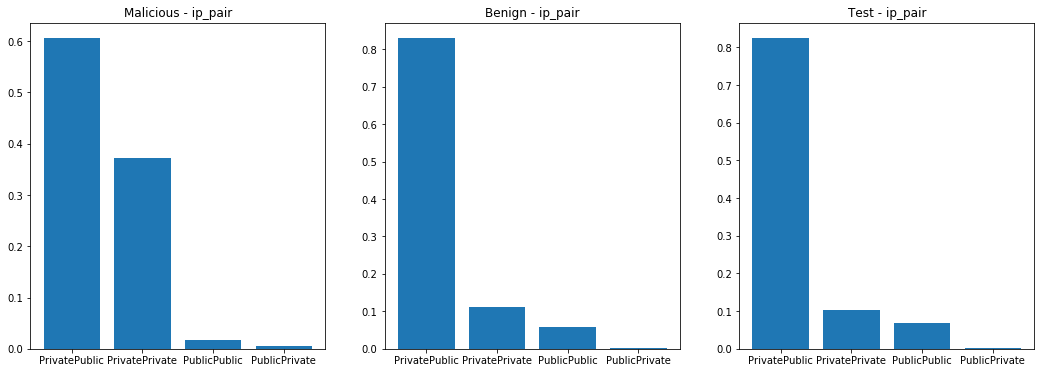

In [12]:
hist_compare3(df_mal, df_benign, df_test, 'ip_pair')

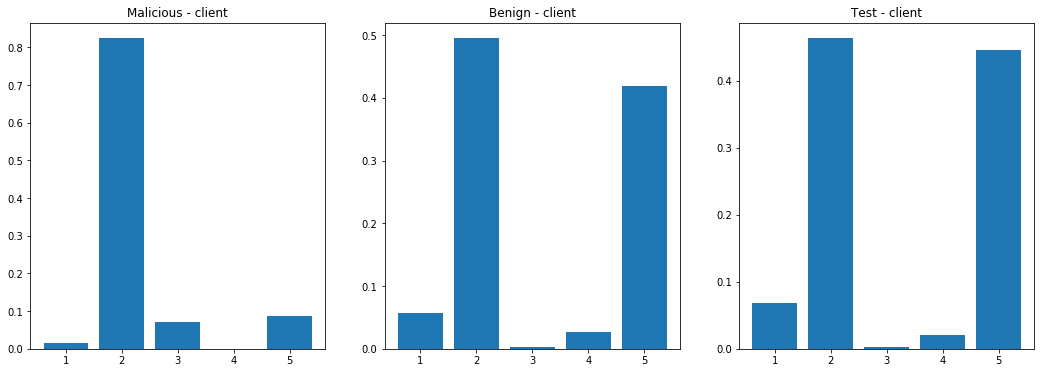

In [14]:
hist_compare3(df_mal, df_benign, df_test, 'client')

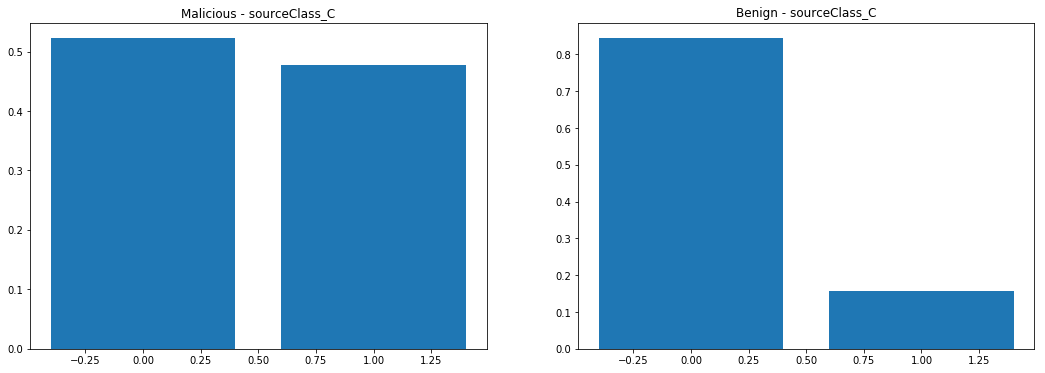

In [73]:
hist_compare(df_mal, df_benign, 'sourceClass_C')

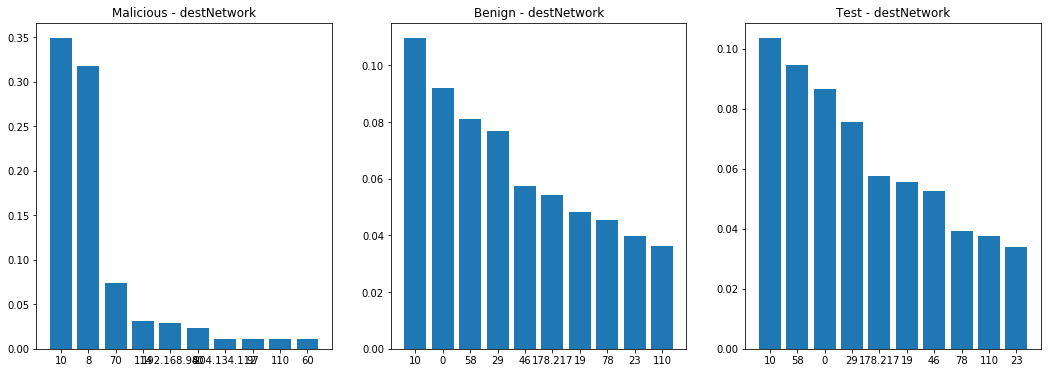

In [15]:
hist_compare3(df_mal, df_benign, df_test, 'destNetwork', 10)

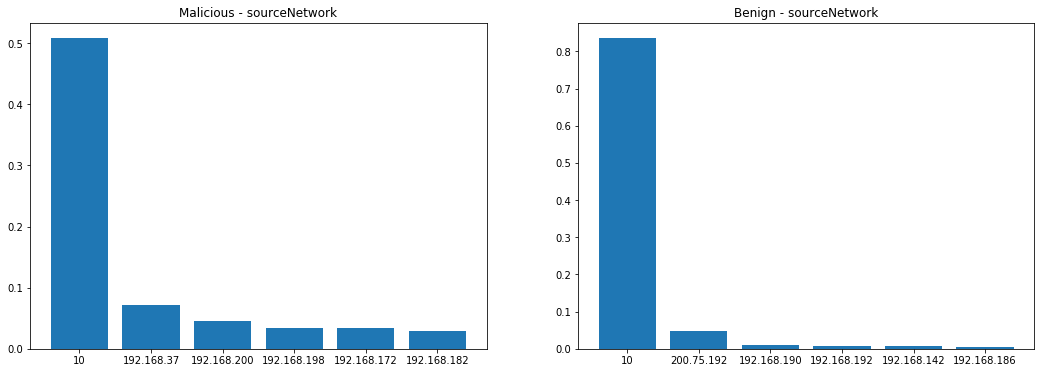

In [16]:
hist_compare(df_mal, df_benign, 'sourceNetwork', 6)

In [17]:
def client_compare(df_mal, feature, limit=None):
    # first group by client
    mal_df = df_mal.groupby('client')
    # plt.figure(figsize=(18, 8))
    # Mal Portion
    mal = []
    mal_i = []
    for n_mal, d_mal in mal_df:
        mal_vals = d_mal[feature].value_counts()
        mal_tot = sum(mal_vals)
        mal_vals_i = mal_vals.index
        mal_dict = {k: v/mal_tot for k, v in zip(mal_vals_i, mal_vals)}
        mal.append(mal_dict)
        mal_i.append(n_mal)
    client_mal = pd.DataFrame(mal, index=mal_i).fillna(0)
    return client_mal

In [18]:
d1 = client_compare(df_mal, 'ip_pair')
d2 = client_compare(df_benign, 'ip_pair')
d3 = client_compare(df_test, 'ip_pair')

In [19]:
d3.head()

PrivatePrivate  PrivatePublic  PublicPrivate  PublicPublic
1        0.000000       0.000000       0.003906      0.996094
2        0.183559       0.816441       0.000000      0.000000
3        0.000000       1.000000       0.000000      0.000000
4        0.057778       0.924444       0.017778      0.000000
5        0.040685       0.955086       0.004230      0.000000

In [20]:
def stacked_client_bar(df_mal, df_benign, feature):
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 2, 1)
    d1.plot(kind='bar', stacked=True, ax=ax)
    plt.title("Malicious: {}".format(feature))
    plt.xlabel("Client")
    ax = plt.subplot(1, 2, 2)
    d2.plot(kind='bar', stacked=True, ax=ax)
    plt.title("Benign: {}".format(feature))
    plt.xlabel("Client")
    plt.show()

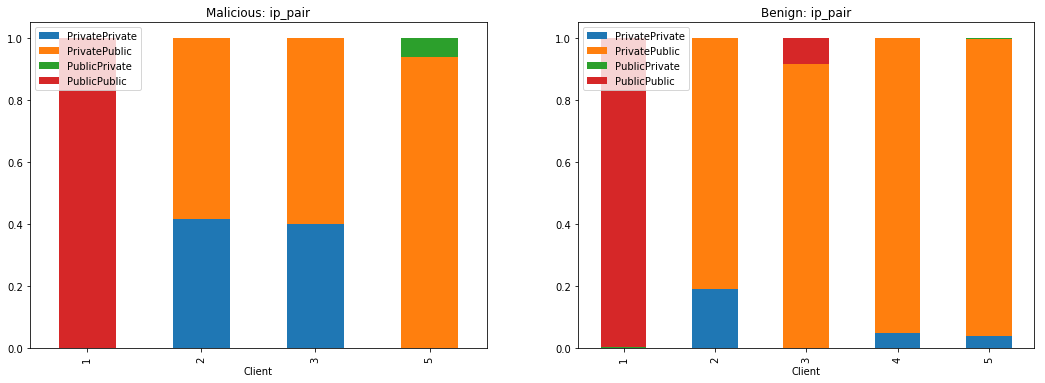

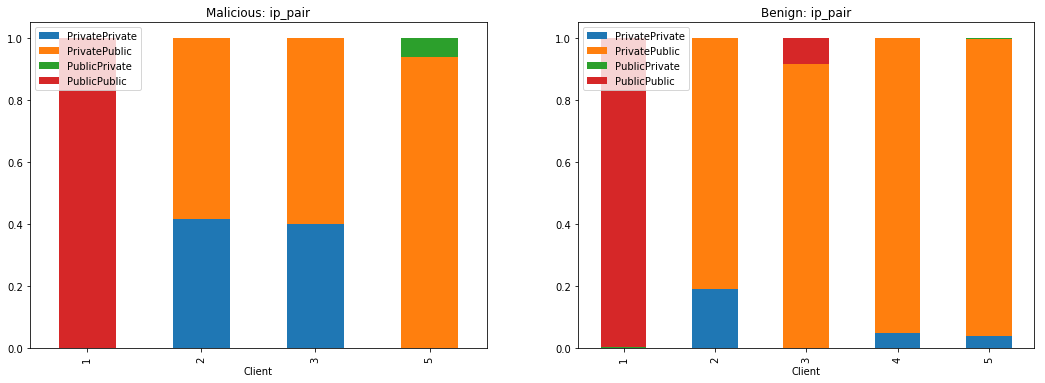

In [22]:
d1 = client_compare(df_mal, 'ip_pair')
d2 = client_compare(df_benign, 'ip_pair')
d3 = client_compare(df_test, 'ip_pair')
stacked_client_bar(d1, d2, 'ip_pair')
stacked_client_bar(d2, d3, 'ip_pair')

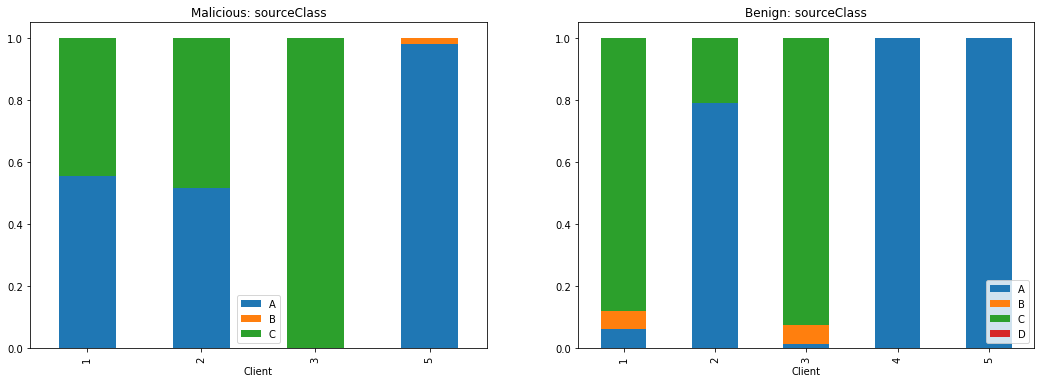

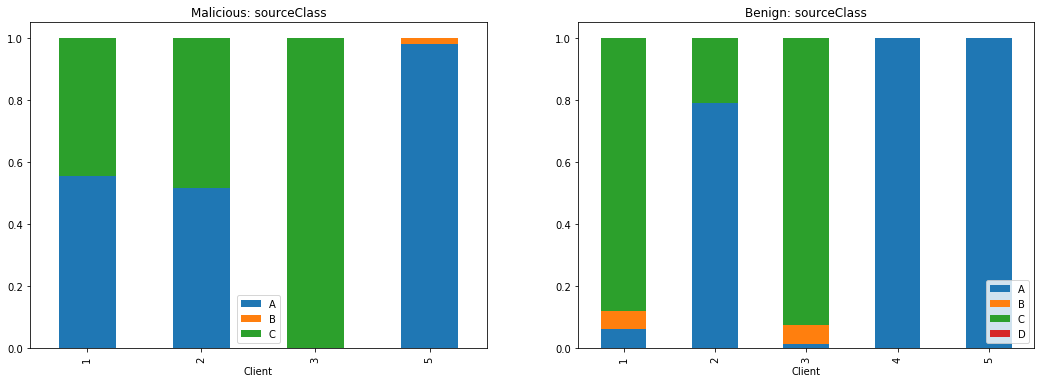

In [27]:
d1 = client_compare(df_mal, 'sourceClass')
d2 = client_compare(df_benign, 'sourceClass')
d3 = client_compare(df_test, 'sourceClass')

stacked_client_bar(d1, d2, 'sourceClass')
stacked_client_bar(d1, d3, 'sourceClass')

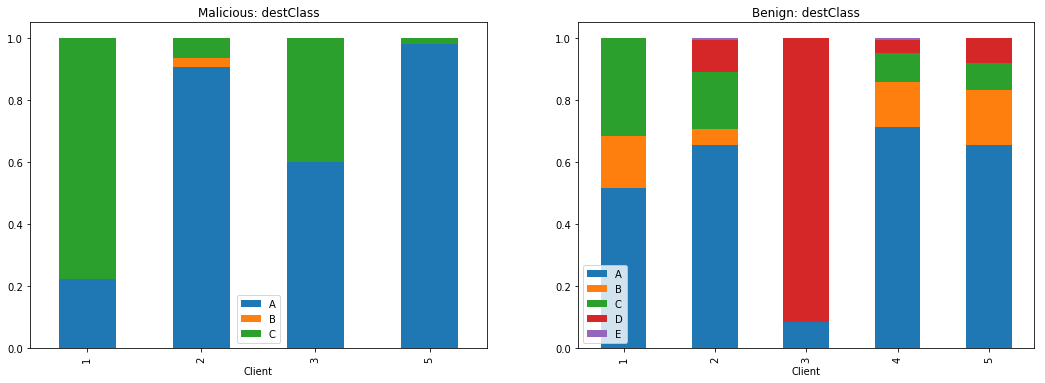

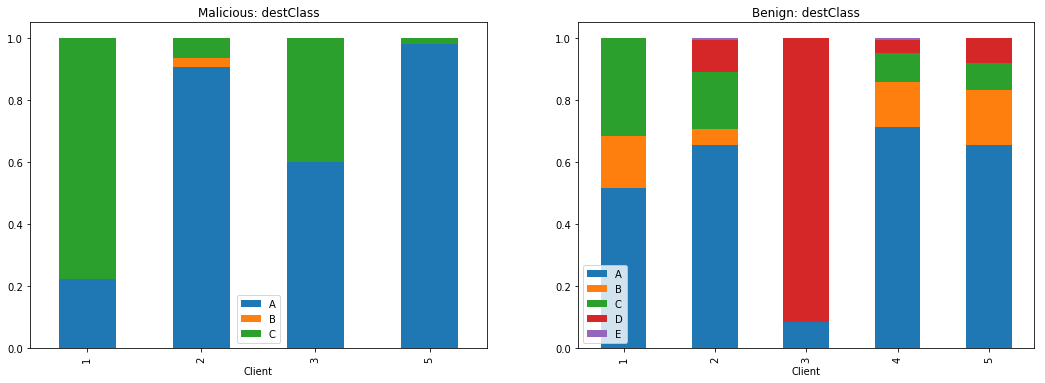

In [24]:
d1 = client_compare(df_mal, 'destClass')
d2 = client_compare(df_benign, 'destClass')
d3 = client_compare(df_test, 'destClass')
stacked_client_bar(d1, d2, 'destClass')
stacked_client_bar(d1, d3, 'destClass')

In [91]:
t = df_benign.destNetwork.value_counts()
ti = t.index
[(i, v) for i, v in enumerate(ti) if v in ('8', '70', '114')]

[(21, '70'), (29, '114'), (45, '8')]

In [93]:
t[21], t[29], t[45]

(399, 271, 126)

In [61]:
mal_vals = df_mal.ip_pair.value_counts()
mal_vals_i = mal_vals.index
mal_vals_i

Index(['PrivatePublic', 'PrivatePrivate', 'PublicPublic', 'PublicPrivate'], dtype='object')

In [47]:
df_mal.ip_pair.value_counts()

PrivatePublic     335
PrivatePrivate    206
PublicPublic        9
PublicPrivate       3
Name: ip_pair, dtype: int64

In [111]:
df_test.head()

Unnamed: 0  client          dst_ip  dst_port protocol  received_bytes  \
0           0       2     230.0.0.251    5353.0      UDP               0   
1           1       2   24.234.32.175     443.0      TCP           15200   
2           2       2  10.200.105.183     443.0      TCP            4712   
3           3       5  178.217.10.142     443.0      TCP           52352   
4           4       5    44.67.14.232      80.0      TCP              92   

   sent_bytes         src_ip  is_port_53  is_port_80      ...        \
0         816  10.197.208.76       False       False      ...         
1         374  10.197.208.78       False       False      ...         
2        5760  10.200.44.127       False       False      ...         
3      114560     10.0.11.80       False       False      ...         
4         132     10.0.11.94       False        True      ...         

  destClass_A destClass_B destClass_C  sourceNetwork  destNetwork  sourceHost  \
0           0           0           0             10            0  197.208.76   
1           1           0           0             10           24  197.208.78   
2           1           0           0             10           10  200.44.127   
3           0           1           0             10      178.217     0.11.80   
4           1           0           0             10           44     0.11.94   

      destHost  DestNetwork10  DestNetwork8  DestNetwork70  
0            0          False         False          False  
1   234.32.175          False         False          False  
2  200.105.183           True         False          False  
3       10.142          False         False          False  
4    67.14.232          False         False          False  

[5 rows x 27 columns]

In [112]:
a =pd.get_dummies(df_test, columns=['client'], drop_first='True')

Unnamed: 0          dst_ip  dst_port protocol  received_bytes  sent_bytes  \
0           0     230.0.0.251    5353.0      UDP               0         816   
1           1   24.234.32.175     443.0      TCP           15200         374   
2           2  10.200.105.183     443.0      TCP            4712        5760   
3           3  178.217.10.142     443.0      TCP           52352      114560   
4           4    44.67.14.232      80.0      TCP              92         132   

          src_ip  is_port_53  is_port_80 dst_type   ...    destNetwork  \
0  10.197.208.76       False       False   Public   ...              0   
1  10.197.208.78       False       False   Public   ...             24   
2  10.200.44.127       False       False  Private   ...             10   
3     10.0.11.80       False       False   Public   ...        178.217   
4     10.0.11.94       False        True   Public   ...             44   

   sourceHost     destHost  DestNetwork10  DestNetwork8  DestNetwork70  \
0  197.208.76            0          False         False          False   
1  197.208.78   234.32.175          False         False          False   
2  200.44.127  200.105.183           True         False          False   
3     0.11.80       10.142          False         False          False   
4     0.11.94    67.14.232          False         False          False   

   client_2  client_3  client_4 client_5  
0         1         0         0        0  
1         1         0         0        0  
2         1         0         0        0  
3         0         0         0        1  
4         0         0         0        1  

[5 rows x 30 columns]

In [116]:
df_test.protocol.value_counts(dropna=False)

TCP    9743
UDP    1415
Name: protocol, dtype: int64

In [ ]:
import requests
r = requests.post('https://http://192.168.1.24:30000/submission',
                   json={ 'team': 'The Dream Team',
                          'password': 'Rider1995',
                          'submission': y_pred_dict
                         },
                   verify=False)
print(r.text)

In [180]:
df_mal.loc[df_mal.client == 2, :].destNetwork.value_counts()[:10]

10             190
8              151
114             17
40              12
110              6
204.134.112      6
97               6
212.189.218      5
60               5
58               5
Name: destNetwork, dtype: int64

In [183]:
inbound_traffic_share = df_mal.groupby(df_mal.client).src_ip.value_counts() / df_mal.groupby(df_mal.client).src_ip.count()

In [184]:
inbound_traffic_share

client  src_ip         
1       200.75.192.252     0.444444
        72.240.205.34      0.333333
        125.23.18.143      0.111111
        95.238.154.247     0.111111
2       10.200.43.110      0.065789
        10.196.74.13       0.050439
        192.168.200.133    0.037281
        10.196.74.10       0.032895
        192.168.172.53     0.021930
        192.168.198.32     0.015351
        10.200.43.20       0.013158
        192.168.155.70     0.013158
        192.168.182.42     0.013158
        192.168.198.57     0.013158
        10.195.20.35       0.010965
        10.197.202.28      0.010965
        10.197.202.6       0.010965
        192.168.170.158    0.010965
        192.168.178.74     0.010965
        192.168.182.65     0.010965
        10.195.144.8       0.008772
        10.195.202.15      0.008772
        10.197.206.12      0.008772
        10.197.206.33      0.008772
        192.168.252.164    0.008772
        10.195.142.74      0.006579
        10.195.144.23      0.006579
    